In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    

In [8]:
import cv2

from torch.utils.data import DataLoader

from MagicPoint.dataset.art_dataset import *
from MagicPoint.model.magic_point import MagicPoint

from common.utils import *
from common.model_utils import detector_loss, detector_metrics, filter_probabilities 


%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
config = load_config('../configs/art_config_test.yaml')
data_config = config['data']
model_config = config['model']
experiment_config = config['experiment']


In [5]:
set_seed(experiment_config['seed'])

test_dataset = ArtificialDataset(available_modes[2], data_config)

test_data_loader = DataLoader(test_dataset, model_config['batch_size'], collate_fn=collate, 
                             shuffle=True)


In [6]:
device = torch.device('cpu')

model = MagicPoint(model_config).to(device)

if experiment_config['load_checkpoints']:
    checkpoint_path = get_checkpoint_path(experiment_config, model_config, 
                                          experiment_config['load_checkpoint_iter'])
    if checkpoint_path.exists():
        epoch, model_sd, optimizer_sd = load_checkpoint(checkpoint_path, map_location=lambda storage, loc: storage)
        model.load_state_dict(model_sd)
        


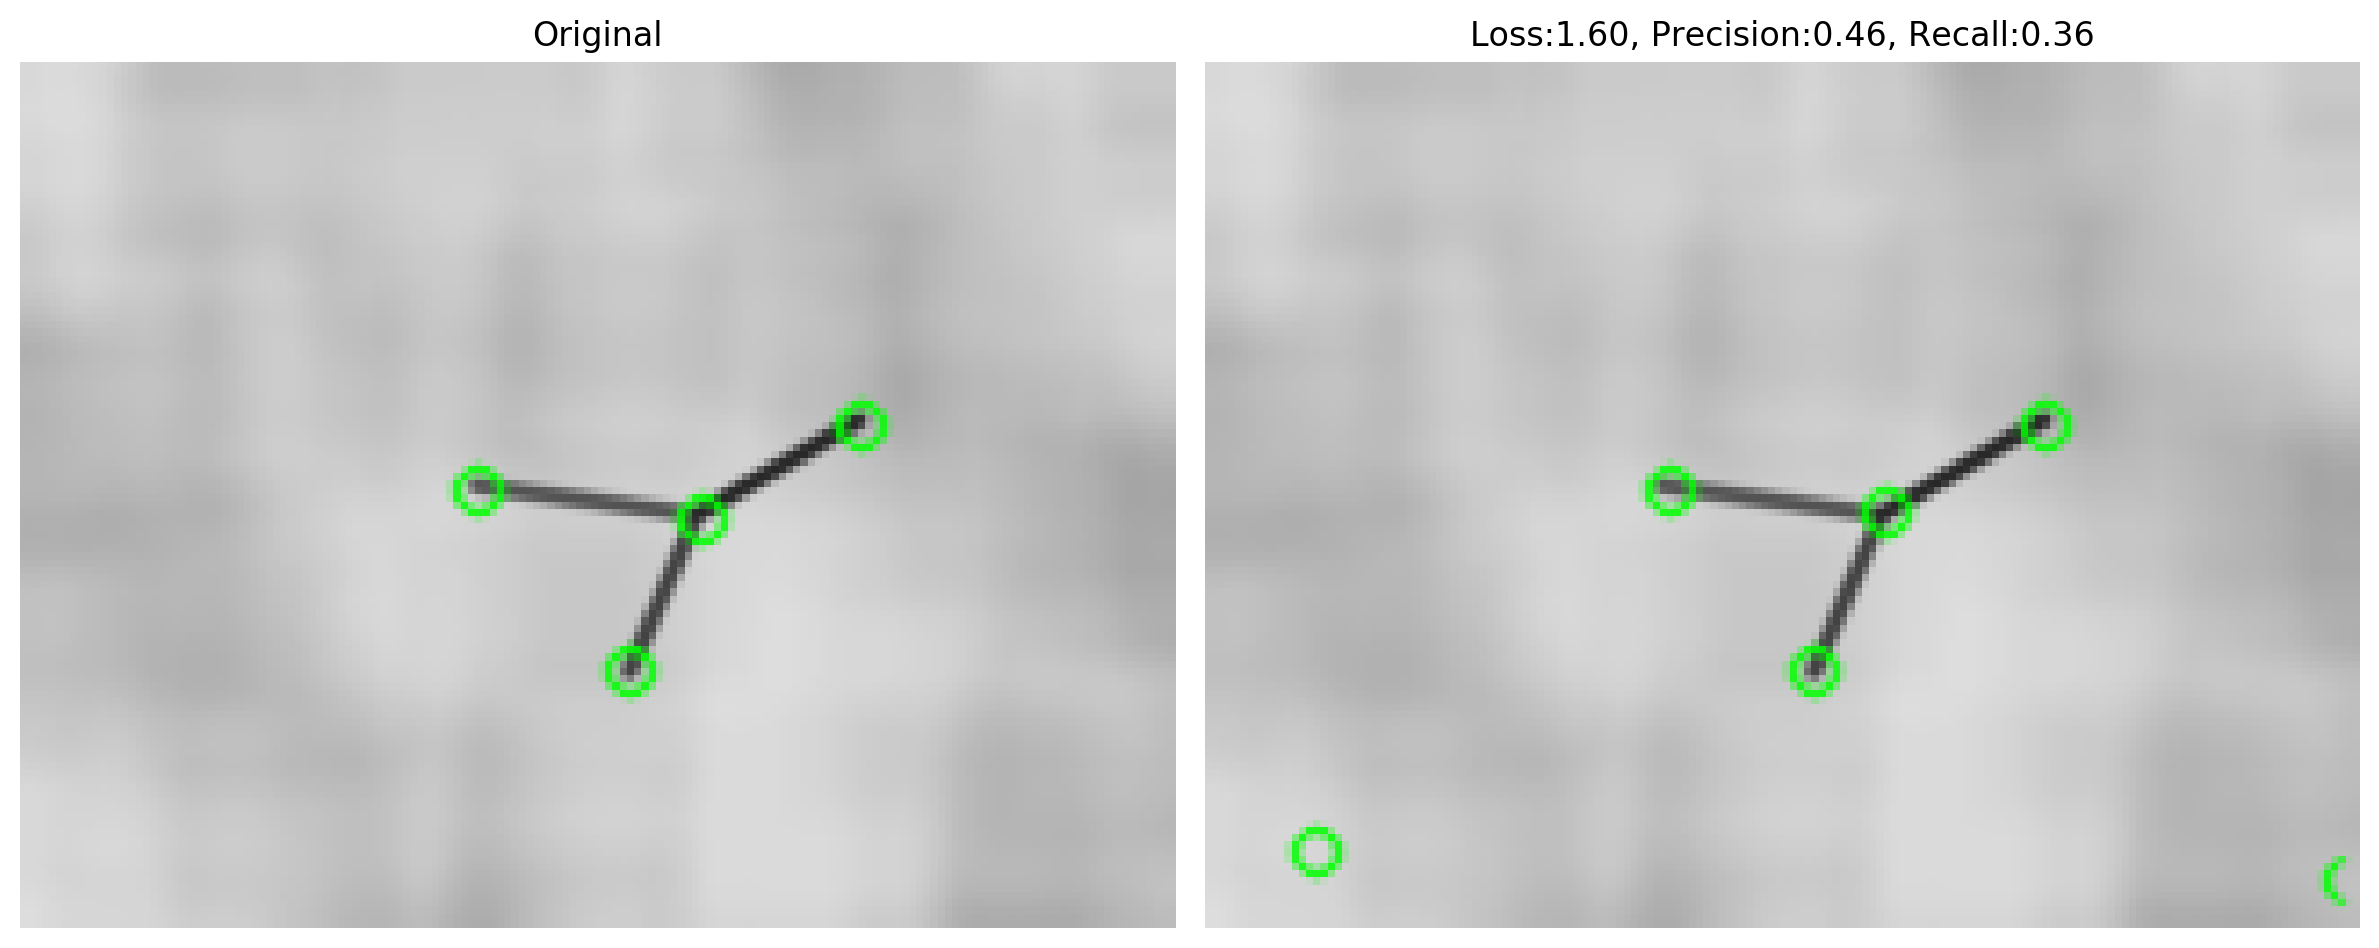

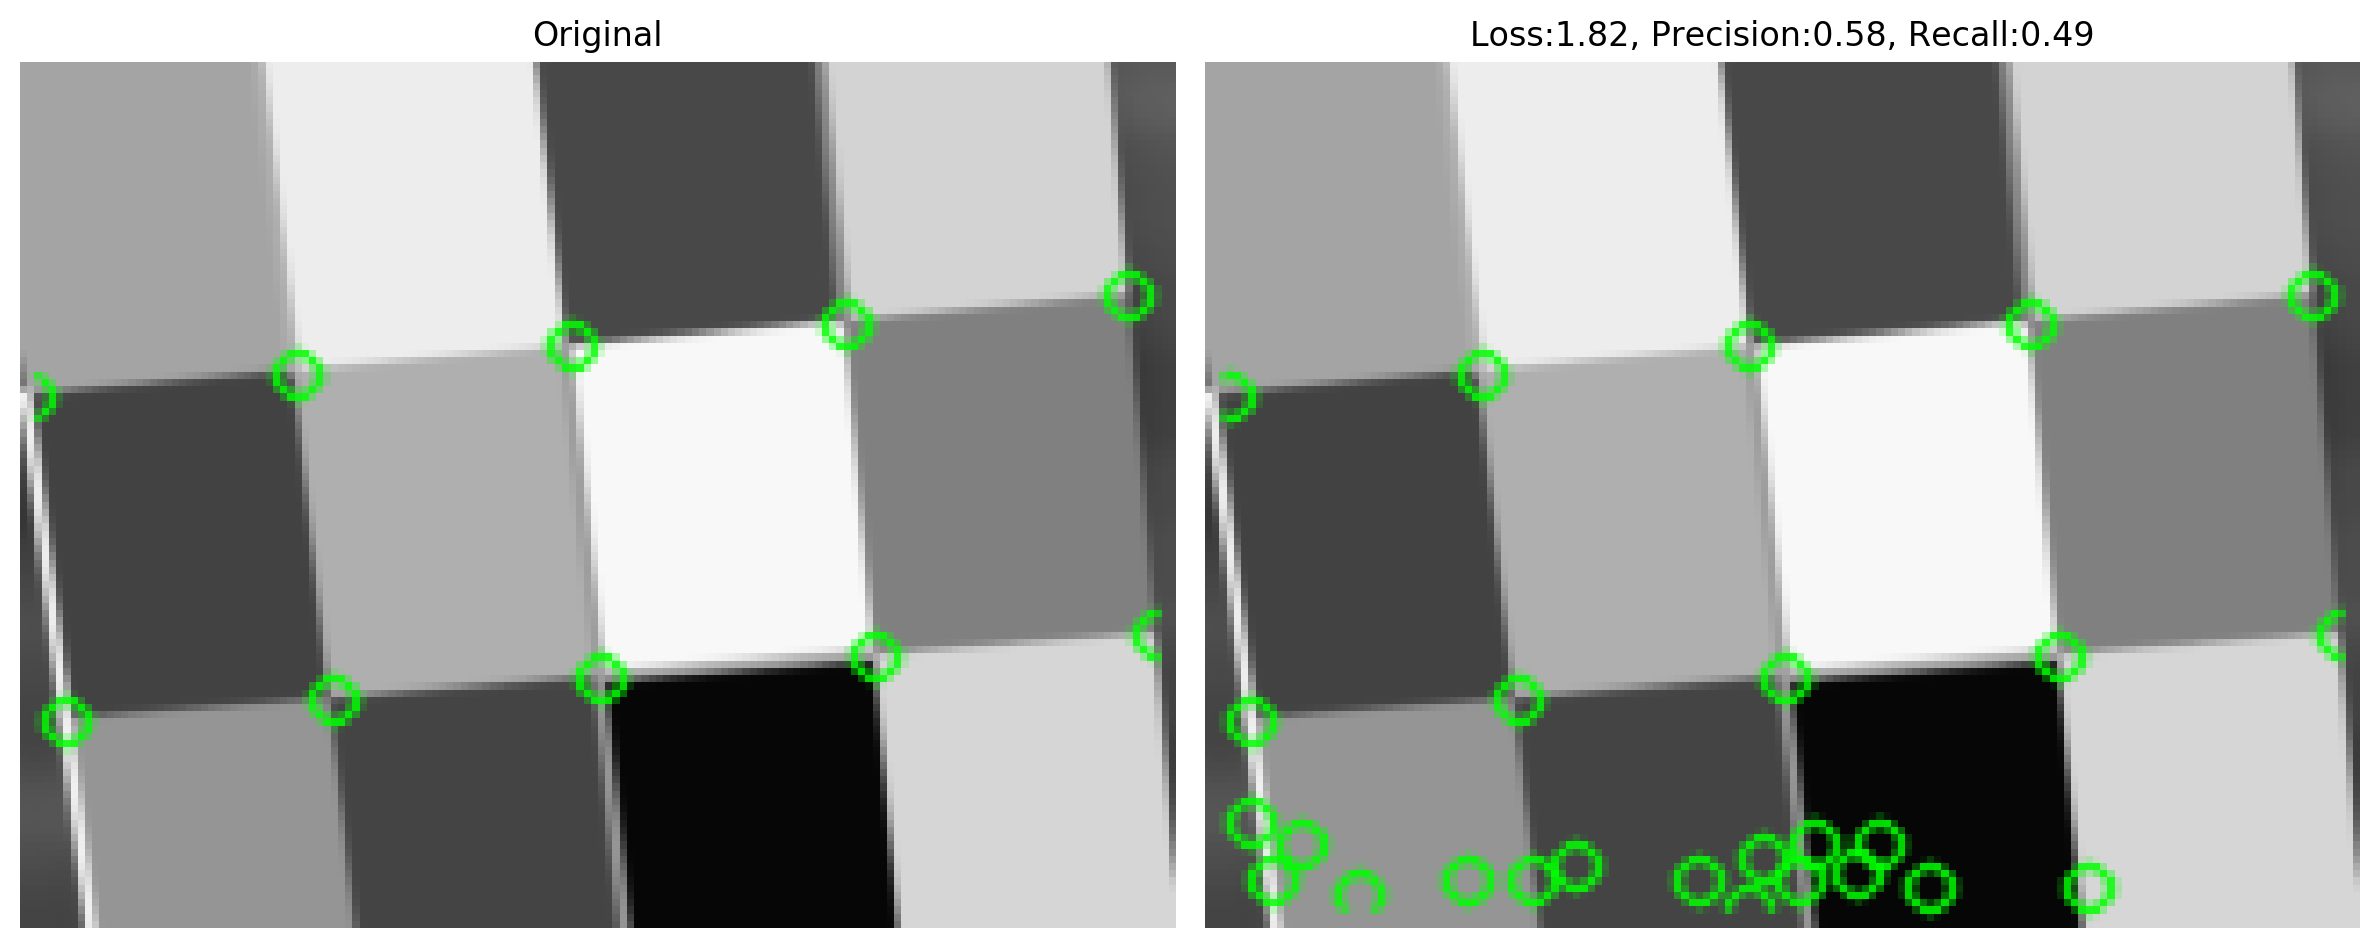

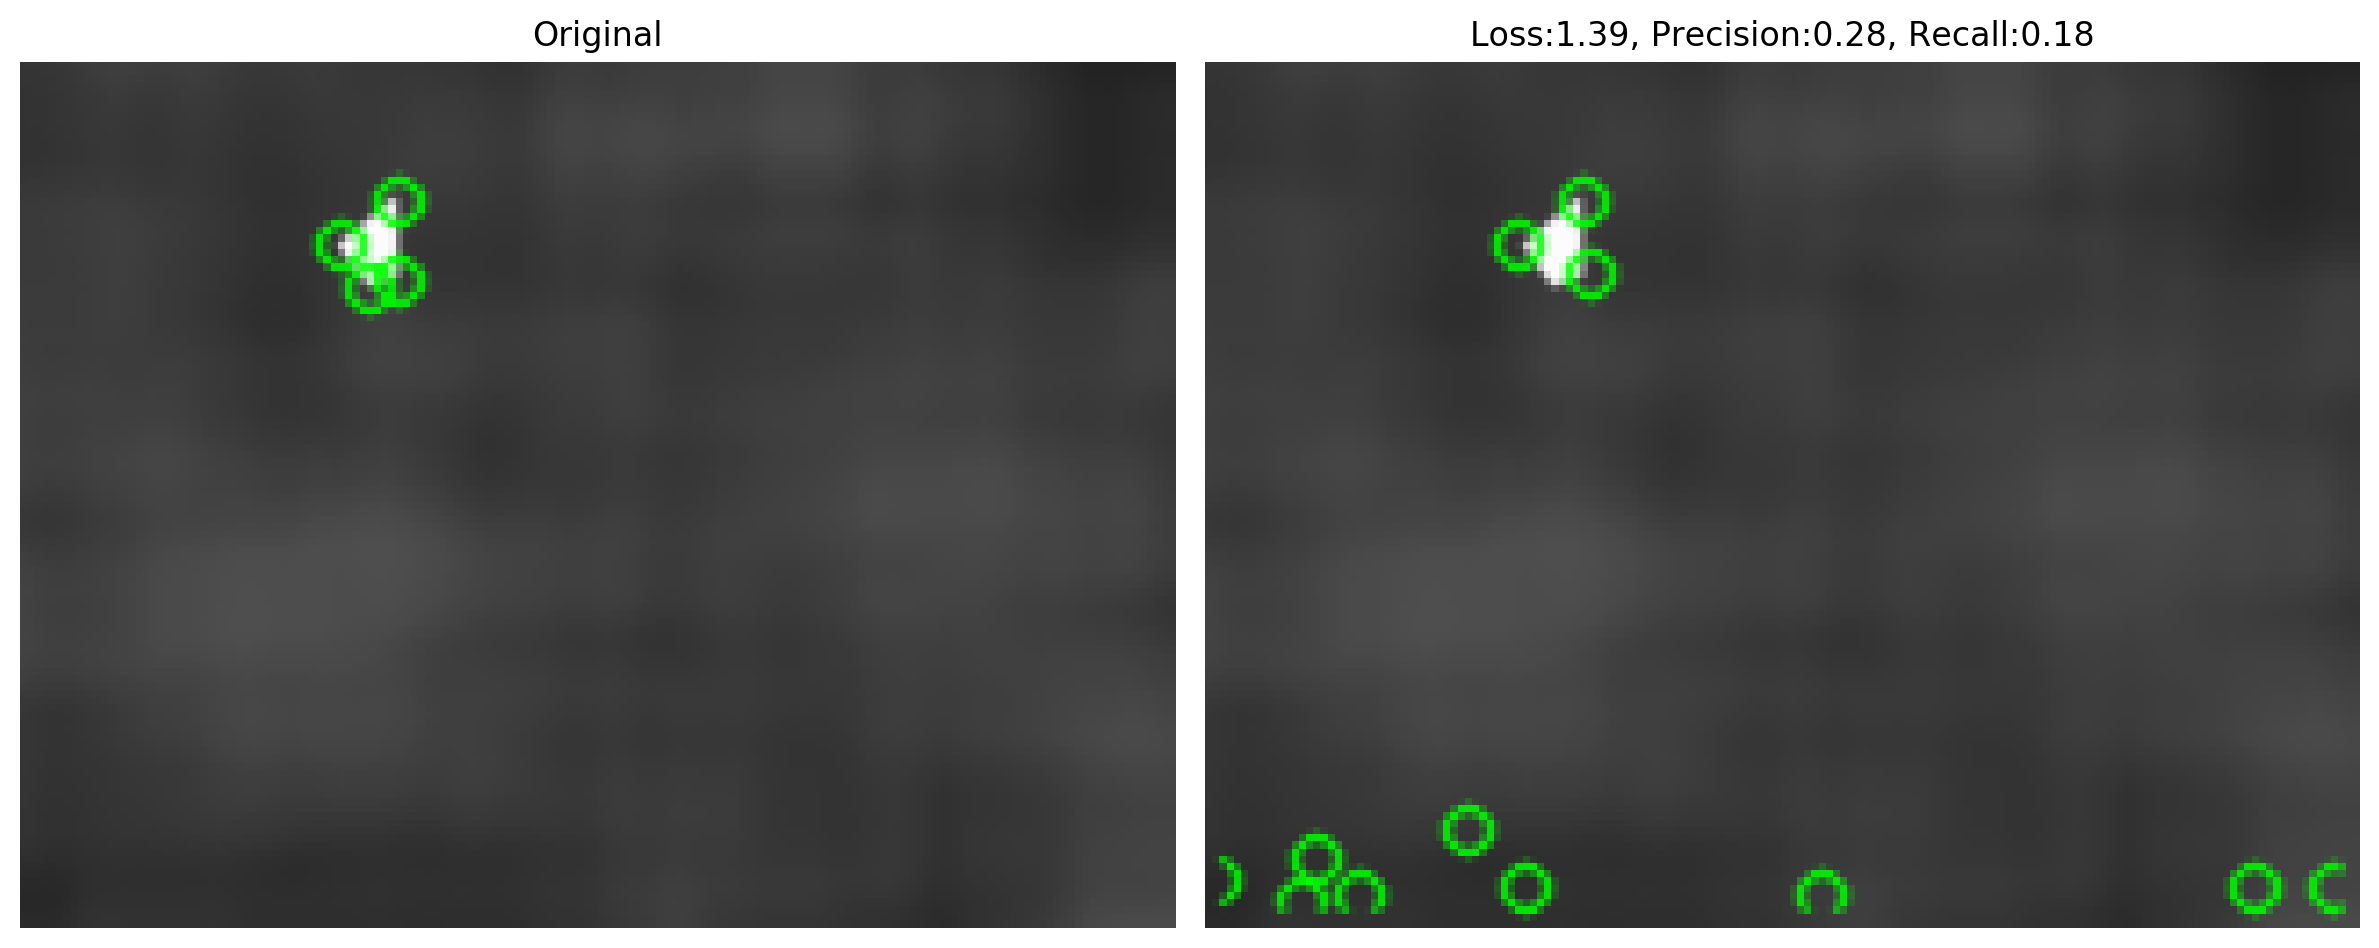

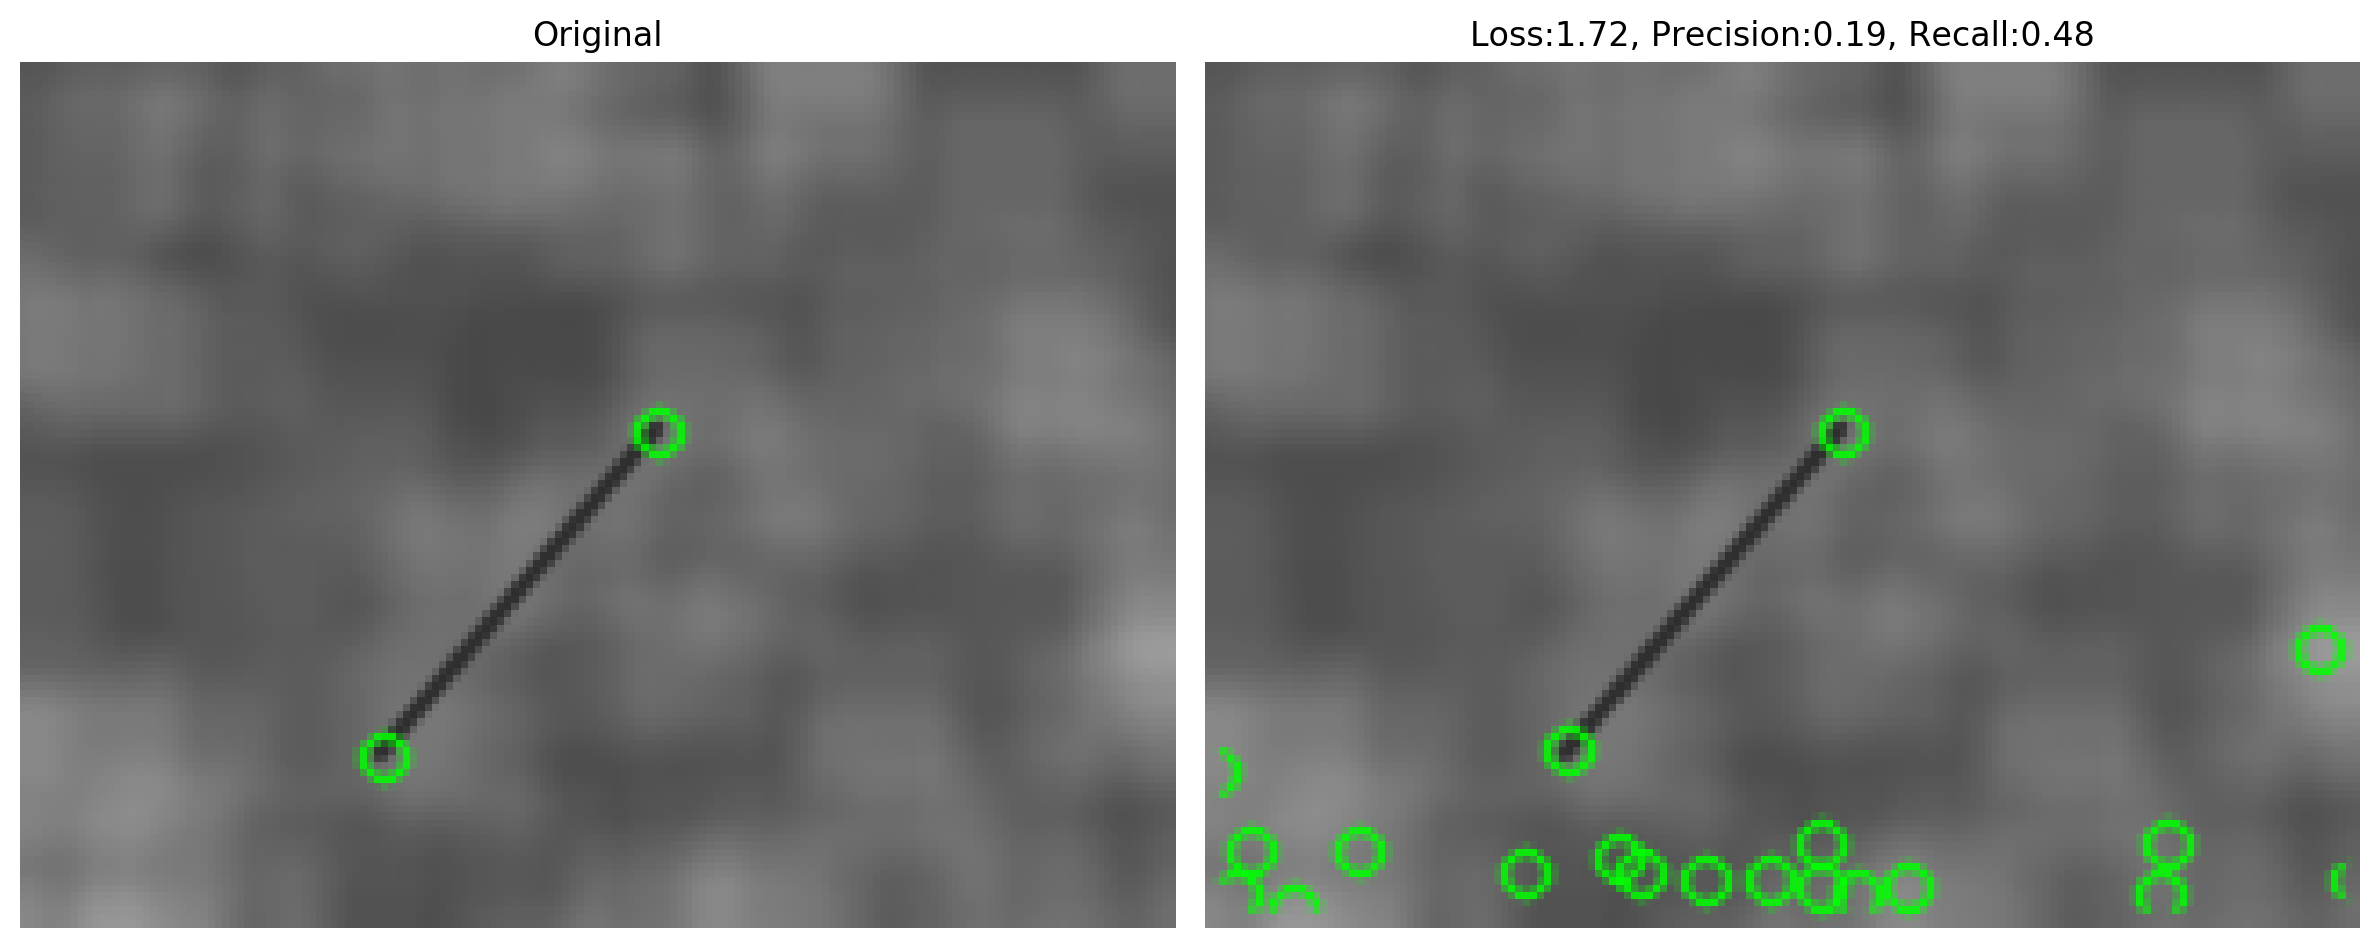

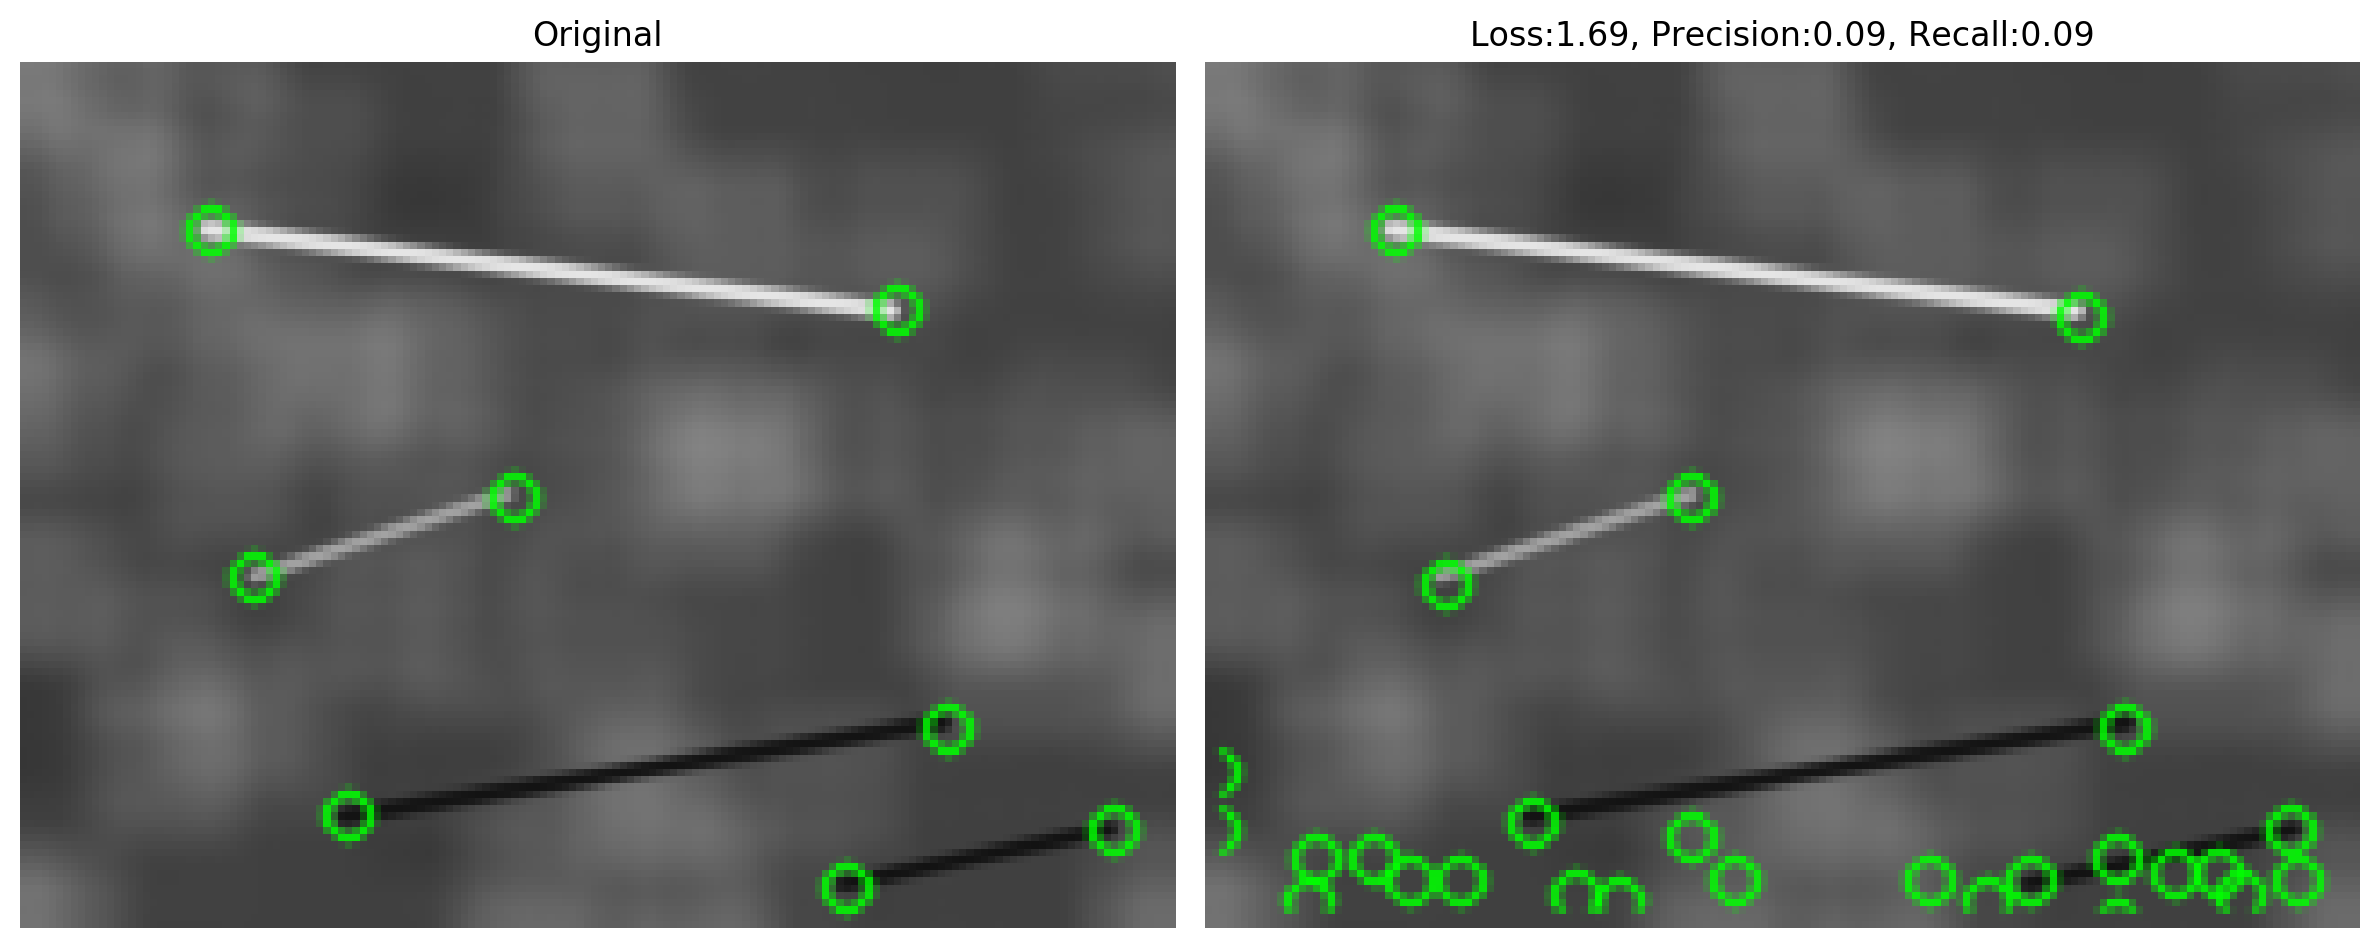

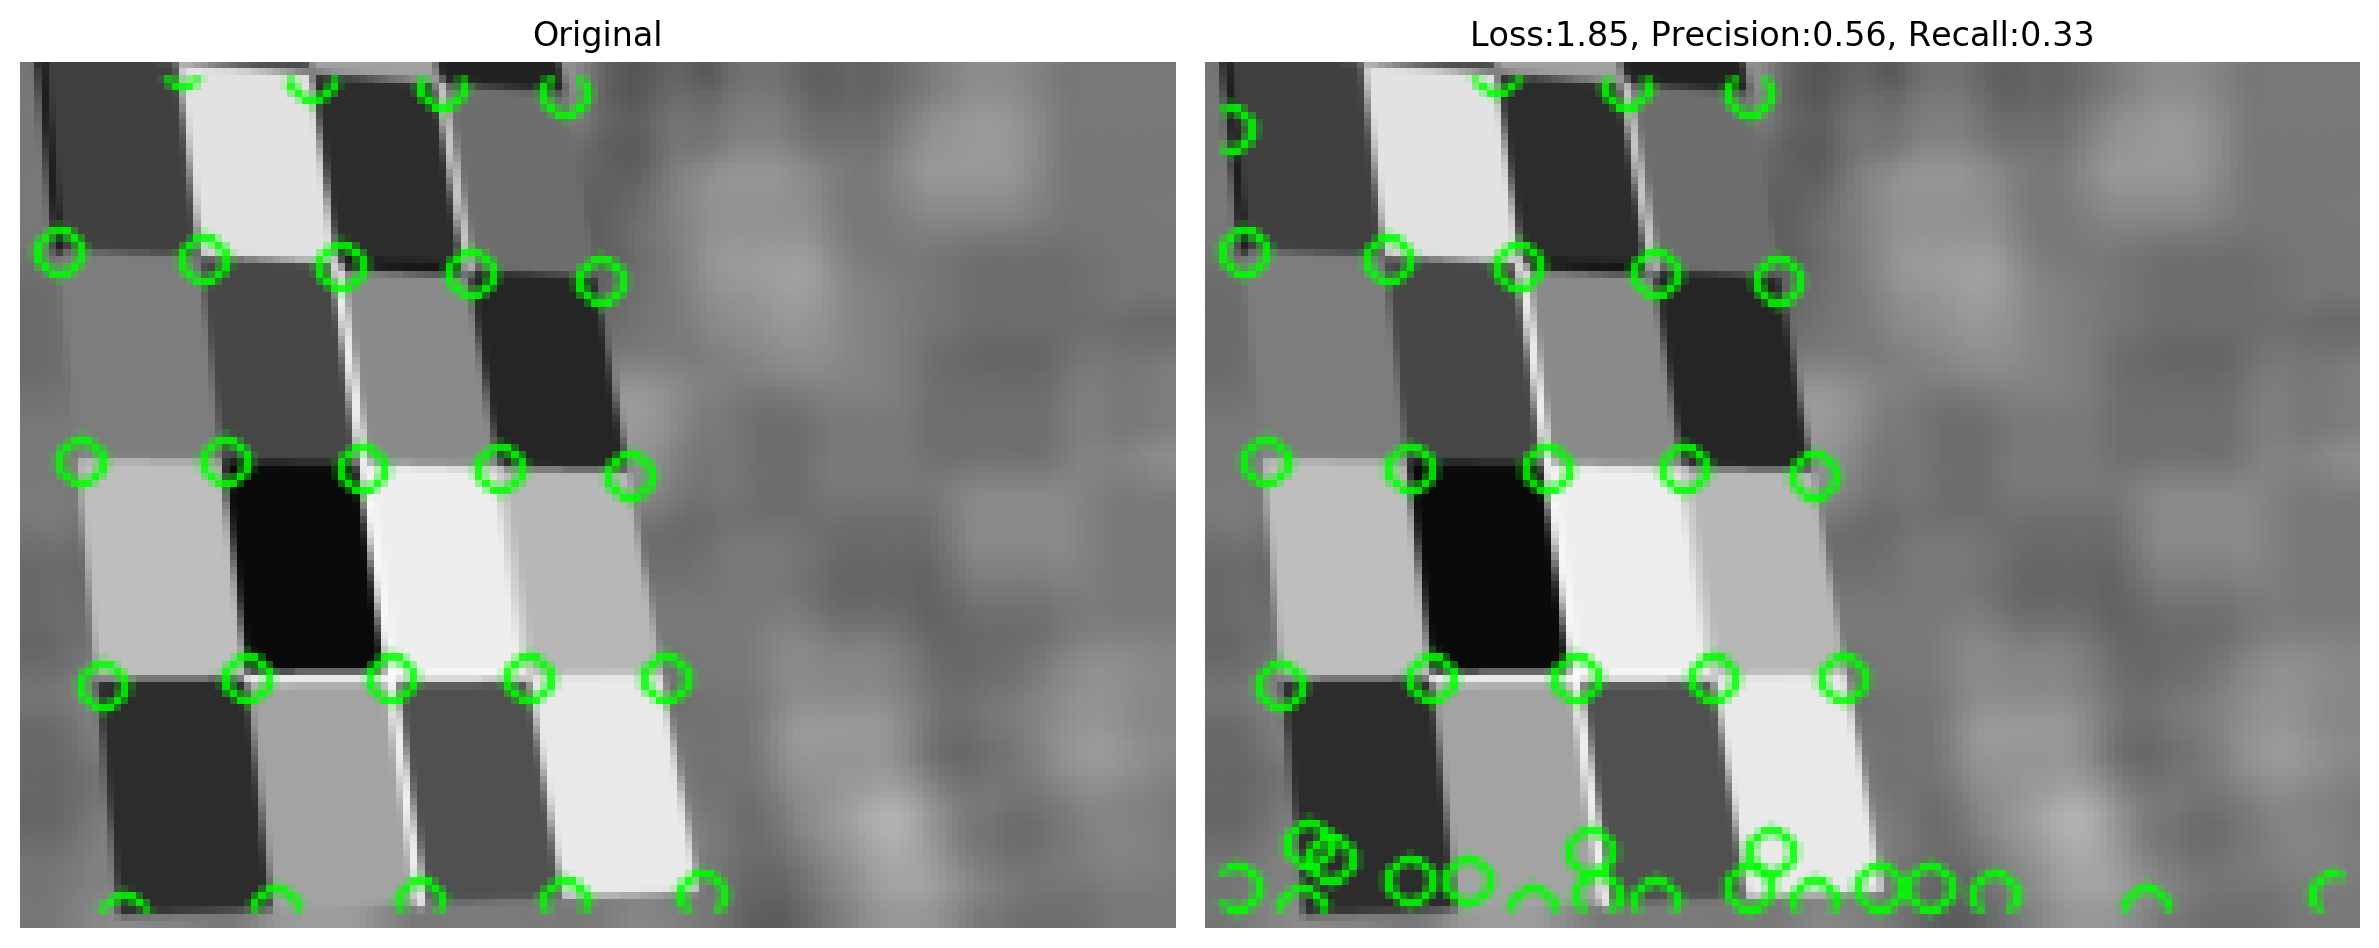

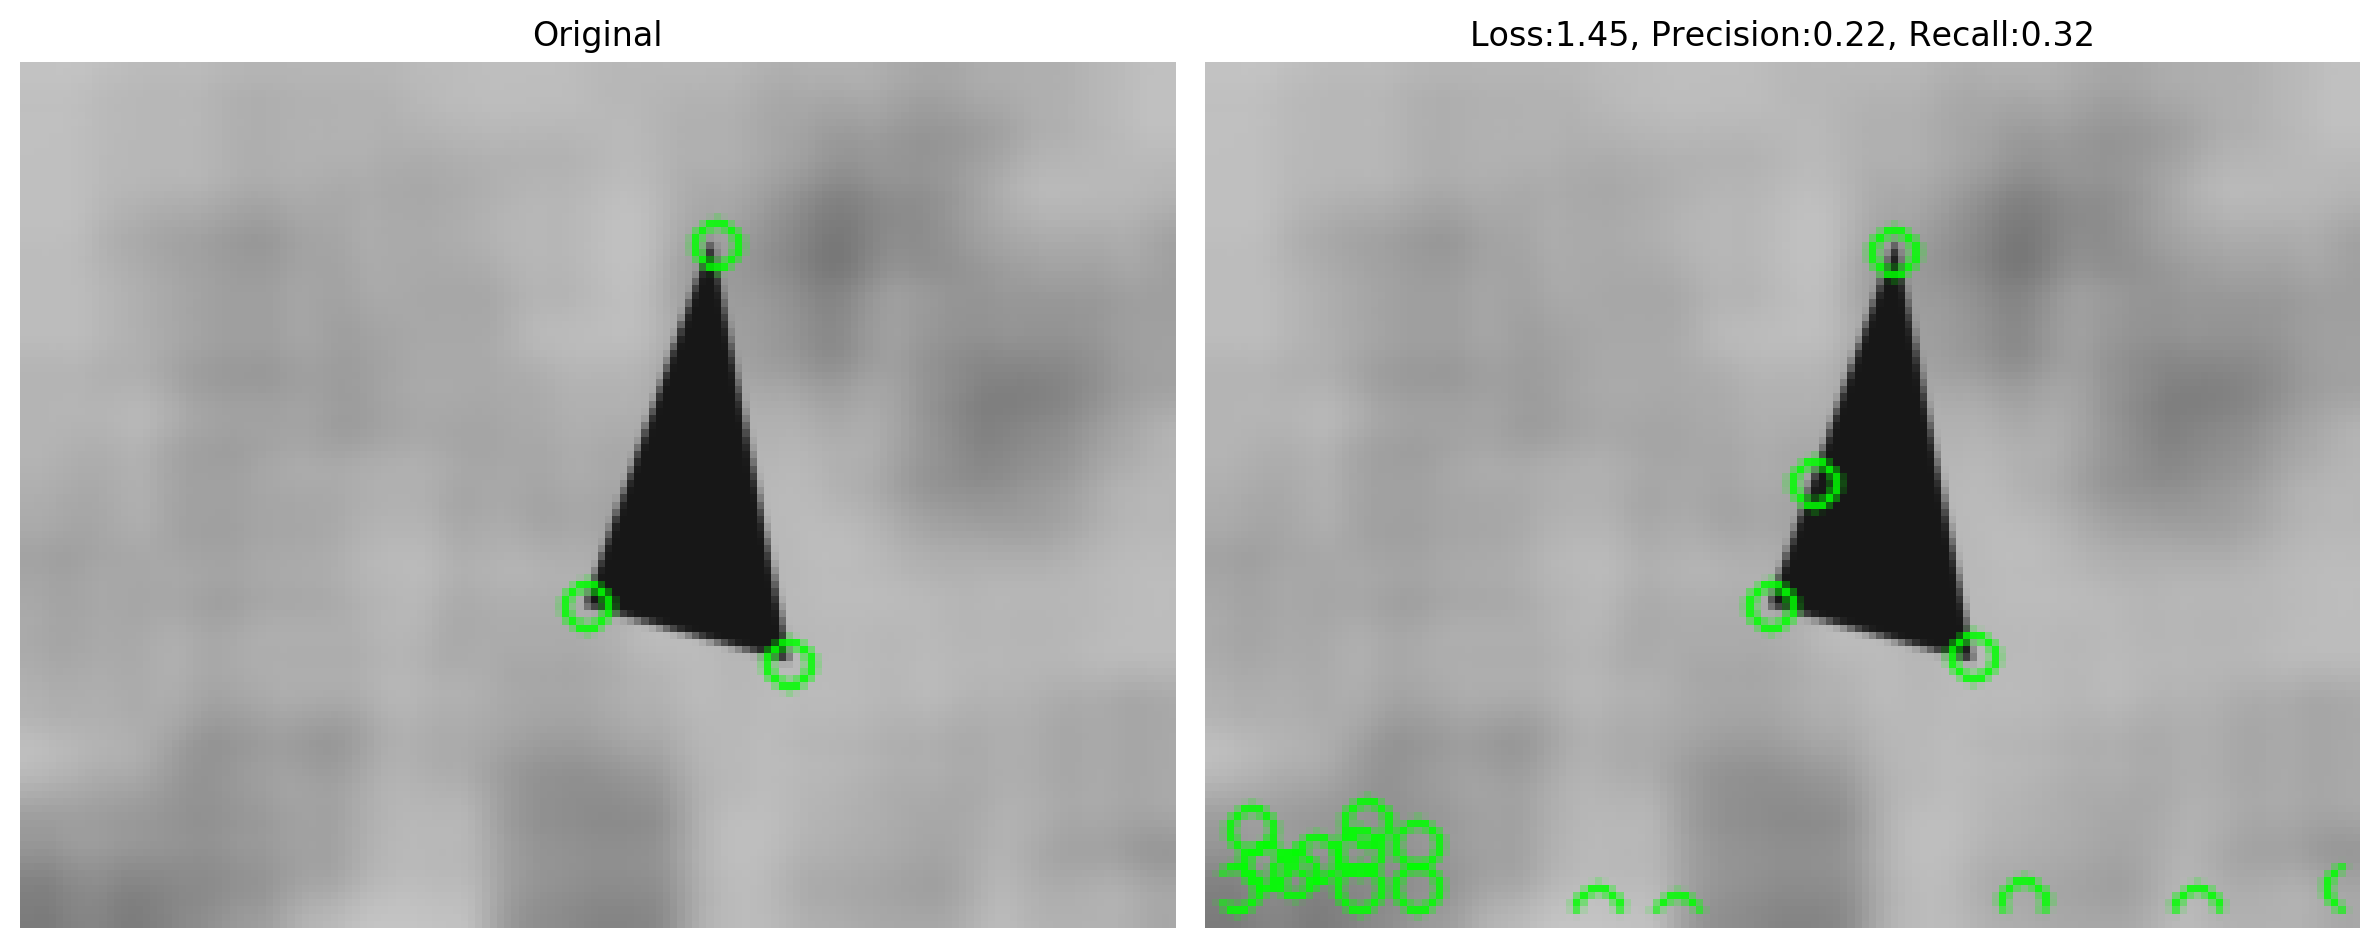

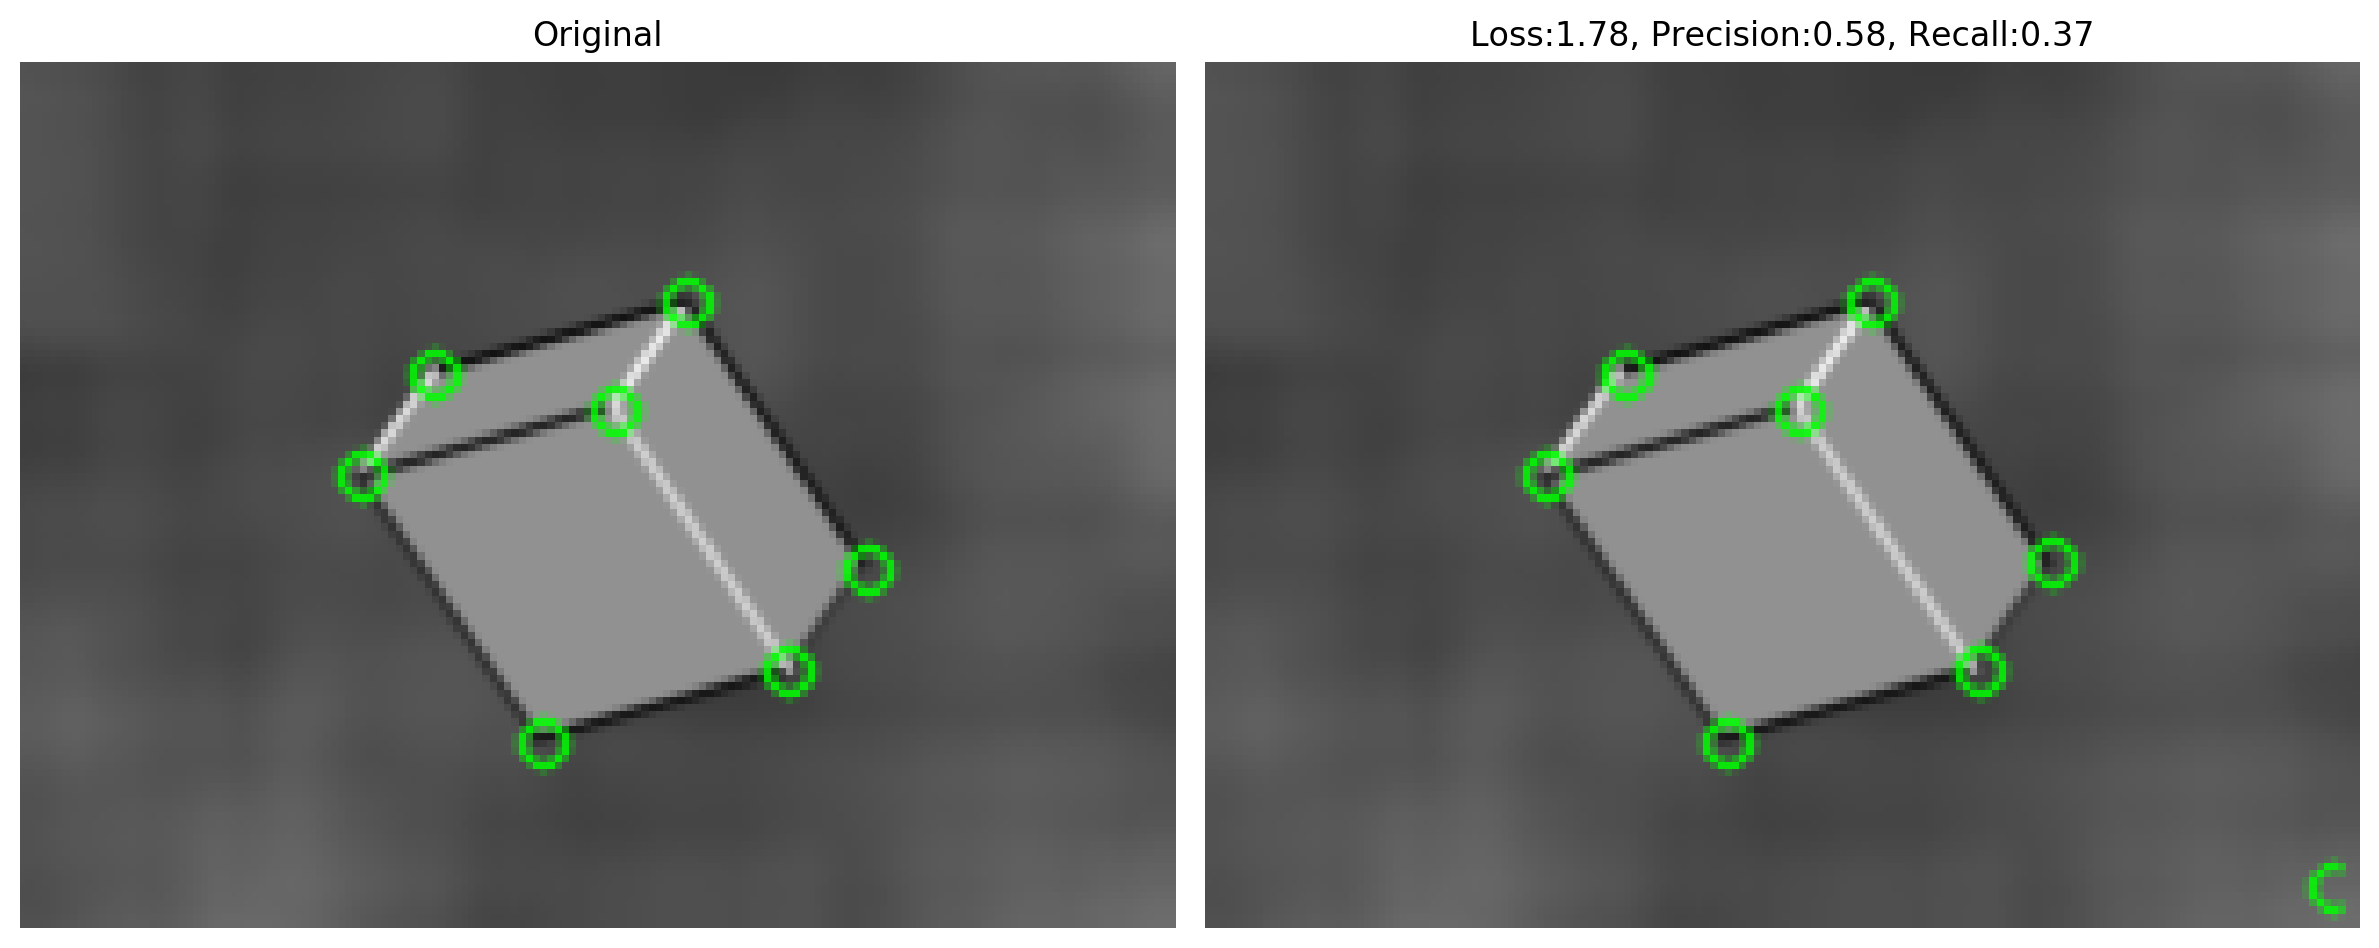

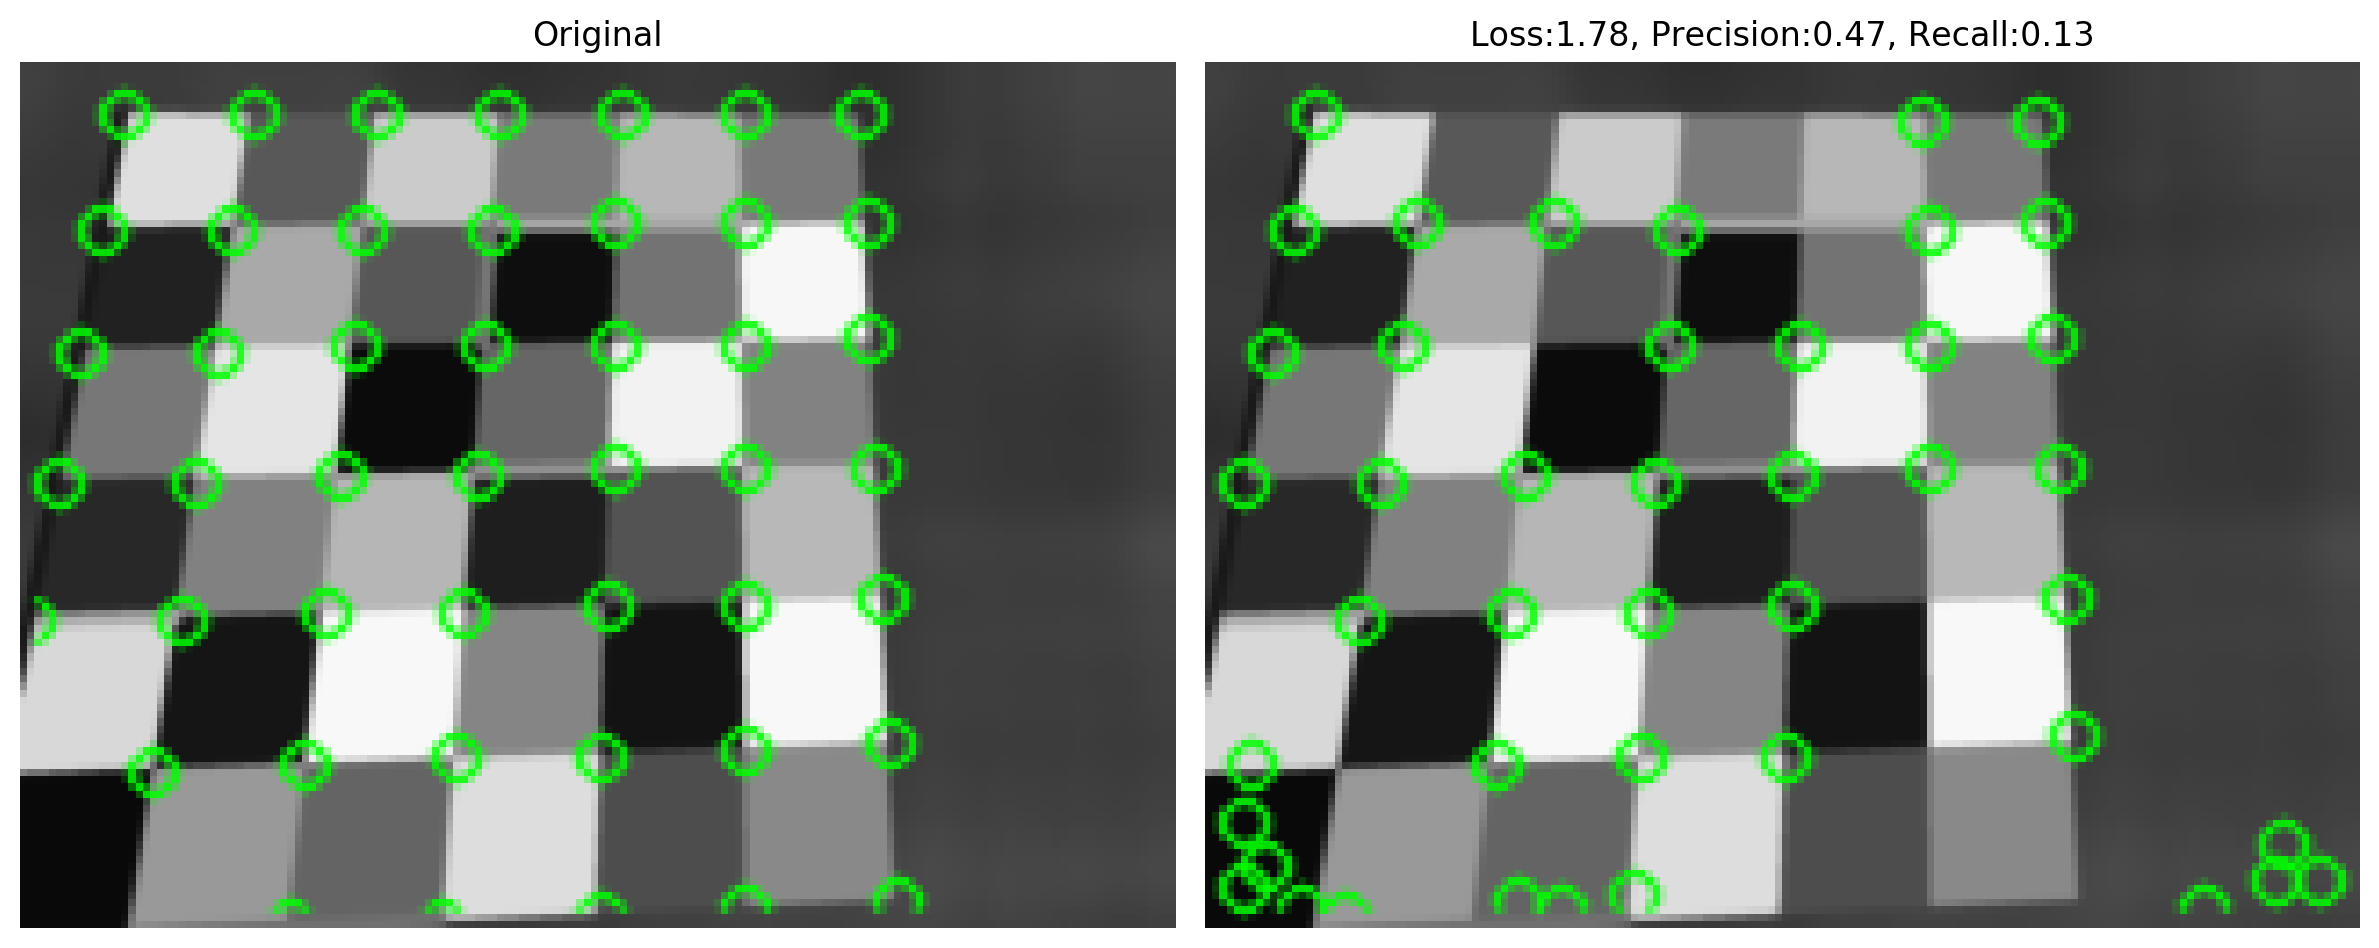

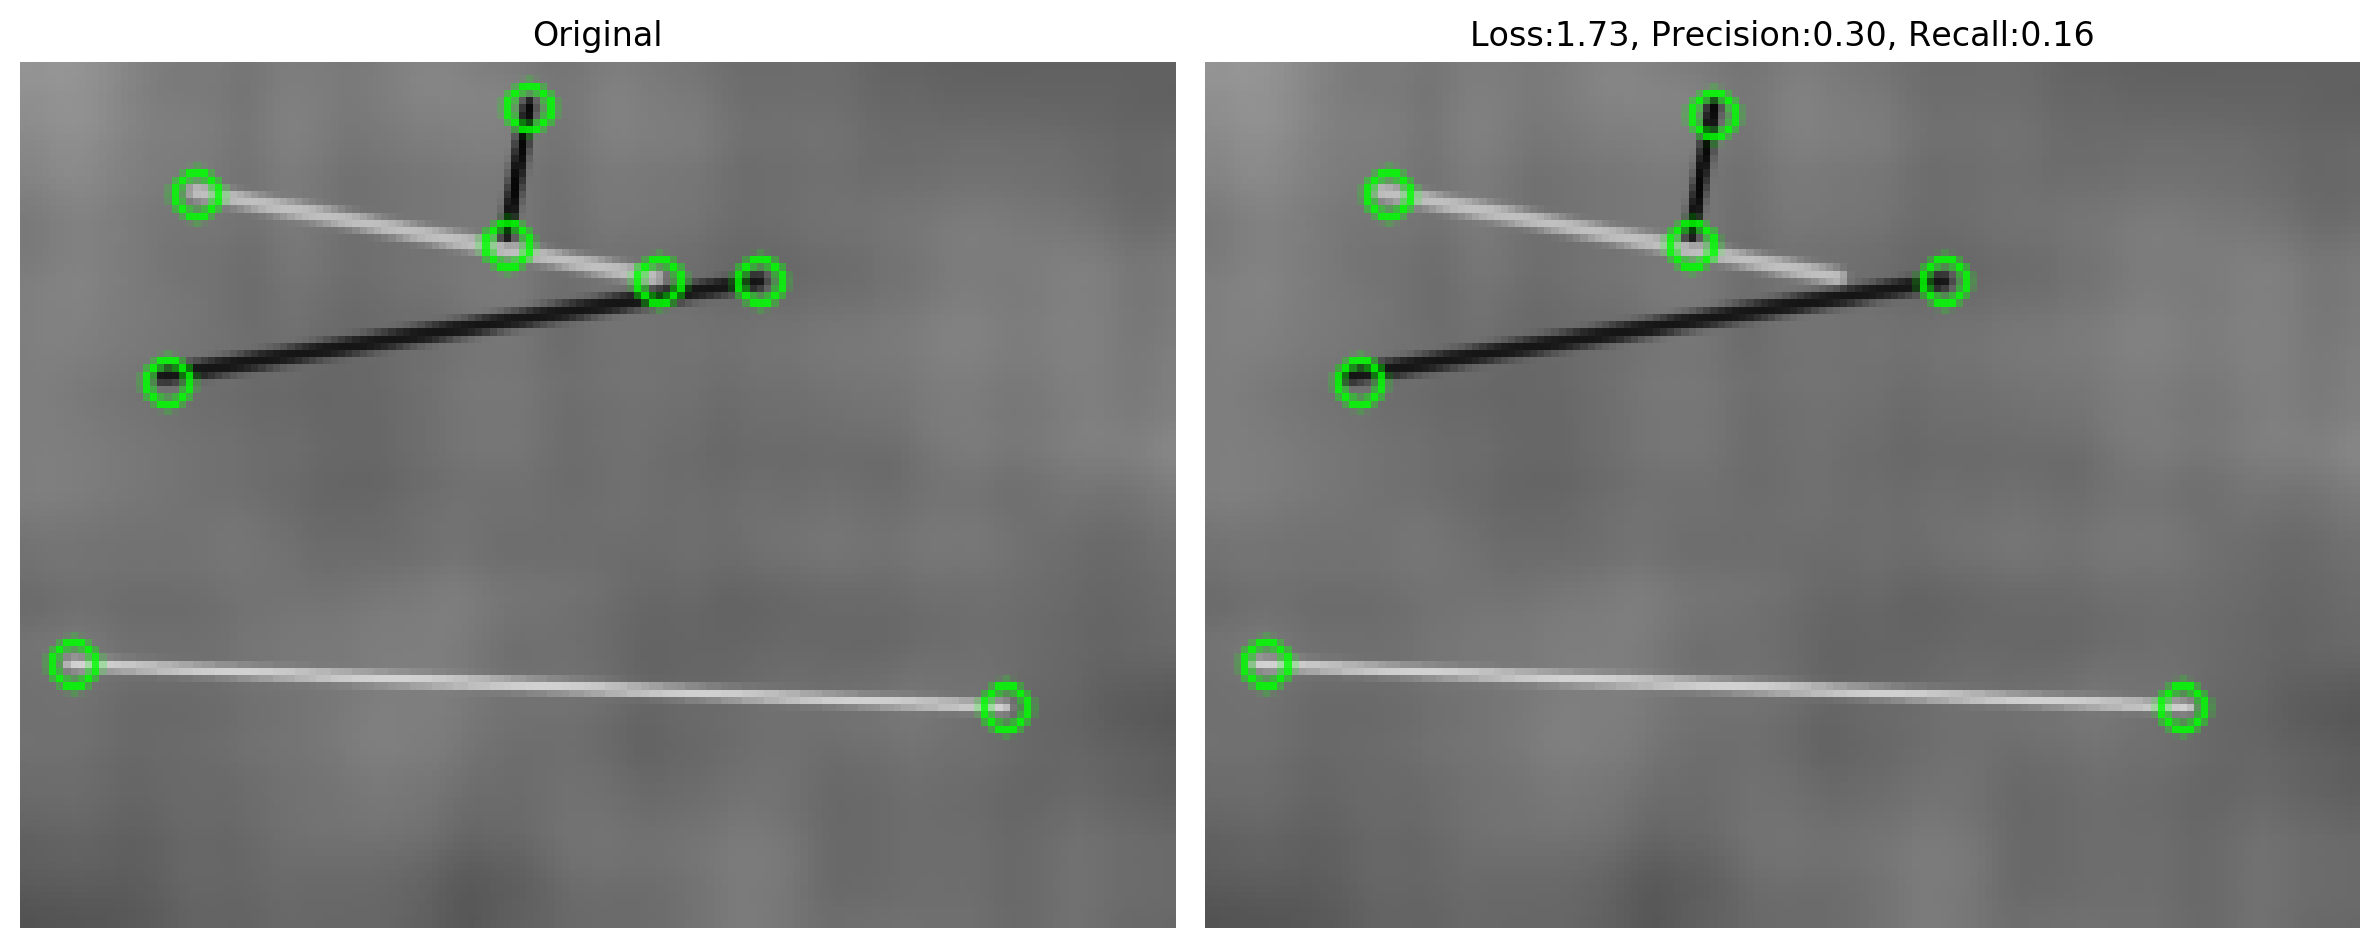

In [7]:
rows = 10

for i in range(rows):
    frames = []
    titles = []
    
    with torch.no_grad():
        item = next(test_data_loader.__iter__())
        
        y_pred = model(item[IMAGE].to(device))
        
        
        loss = detector_loss(y_pred['logits'].to(device), item[KEYPOINT_MAP].to(device), item[MASK].to(device), device, model_config)
        
        probs = filter_probabilities(y_pred['probs'], model_config)
        
        metrics = detector_metrics(probs, item[KEYPOINT_MAP].to(device))
        precision = metrics['precision'].cpu().item()
        recall = metrics['recall'].cpu().item()
        
        title = "Loss:{:.2f}, Precision:{:.2f}, Recall:{:.2f}".format(loss, precision, recall)
        
        titles.append("Original")
        titles.append(title)
        
        image = to255scale(item[IMAGE].detach().numpy()[0]).transpose((1, 2, 0))
        image_keypoints = [cv2.KeyPoint(c[1], c[0], 1) for c in np.stack(np.where(item[KEYPOINT_MAP][0])).T]
        image_and_keypoints = cv2.drawKeypoints(image, image_keypoints, None, color=(0, 255, 0))
        
        prob_map = probs.detach().numpy()
        prob_keypoints = [cv2.KeyPoint(c[1], c[0], 1) for c in np.stack(np.where(prob_map)).T]
        prob_and_keypoints = cv2.drawKeypoints(image, prob_keypoints, None, color=(0, 255, 0))
        
        frames.append(image_and_keypoints)
        frames.append(prob_and_keypoints)
    
    plot_images(frames, titles, dpi=200)
